### Part d): Classification  analysis using neural networks

With a well-written code it should now be easy to change the
activation function for the output layer.

Here we will change the cost function for our neural network code
developed in parts b) and c) in order to perform a classification analysis. 

We will here study the Wisconsin Breast Cancer  data set. This is a typical binary classification problem with just one single output, either True or Fale, $0$ or $1$ etc.
You find more information about this at the [Scikit-Learn
site](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) or at the [University of California
at Irvine](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)). 

To measure the performance of our classification problem we use the
so-called *accuracy* score.  The accuracy is as you would expect just
the number of correctly guessed targets $t_i$ divided by the total
number of targets, that is

$$
\text{Accuracy} = \frac{\sum_{i=1}^n I(t_i = y_i)}{n} ,
$$

where $I$ is the indicator function, $1$ if $t_i = y_i$ and $0$
otherwise if we have a binary classification problem. Here $t_i$
represents the target and $y_i$ the outputs of your FFNN code and $n$ is simply the number of targets $t_i$.

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$ (as you did in Ridge Regression), various activation functions, number of hidden layers and nodes and activation functions.  

As stated in the introduction, it can also be useful to study other
datasets. 

Again, we strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

# Classification using own code

### Imports and loading the datasets

In [104]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import pickle
import os 

# Loading dataset
np.random.seed(0)        #create same seed for random number every time
cancer=load_breast_cancer()      #Download breast cancer dataset
inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

#Print information about the datasets
print('The content of the breast cancer dataset is:')
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

#Reassign the Feature and Label matrices to other variables
x = inputs 
y = outputs

The content of the breast cancer dataset is:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
-------------------------
inputs =  (569, 30)
outputs =  (569,)
labels =  (30,)


### Visualisation of dataset

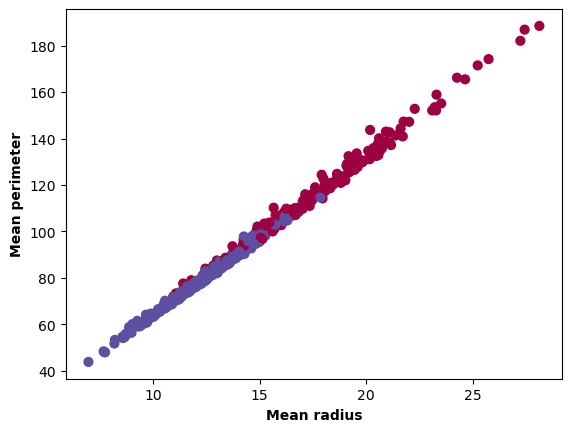

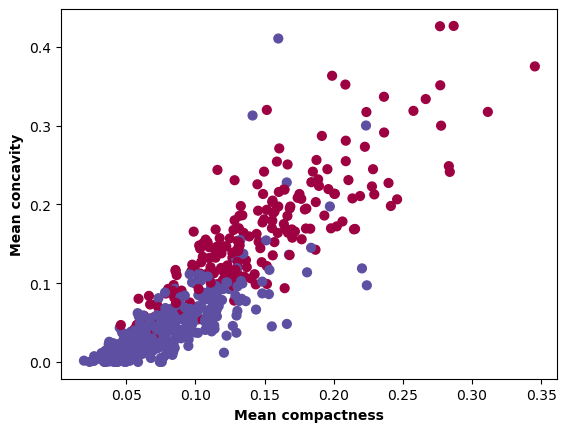

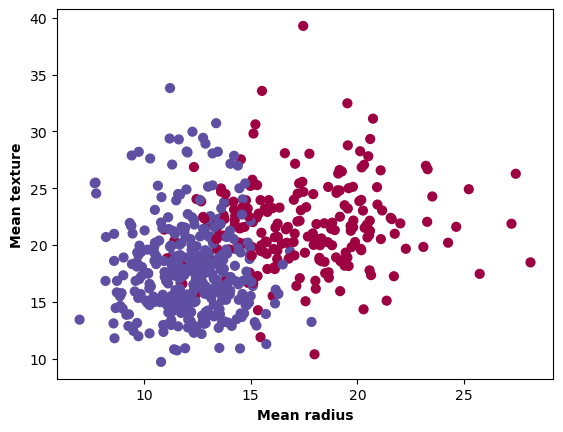

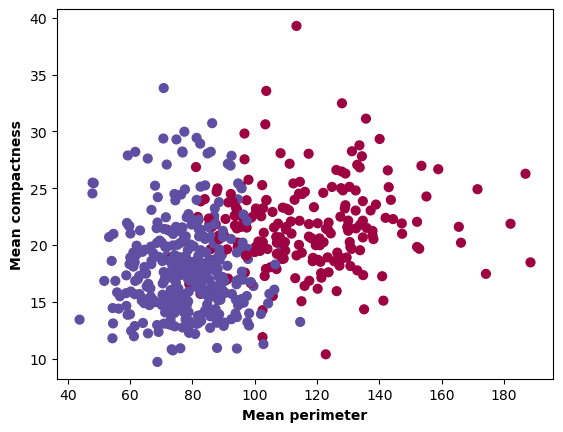

In [105]:
plt.figure()
plt.scatter(x[:,0],x[:,2],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean perimeter',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,5],x[:,6],s=40,c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness',fontweight='bold')
plt.ylabel('Mean concavity',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,0],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean radius',fontweight='bold')
plt.ylabel('Mean texture',fontweight='bold')
plt.show()

plt.figure()
plt.scatter(x[:,2],x[:,1],s=40,c=y,cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter',fontweight='bold')
plt.ylabel('Mean compactness',fontweight='bold')
plt.show()

### Functions

In [106]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def train_test_split_numpy(inputs, labels, train_size, test_size):
    n_inputs = len(inputs)
    inputs_shuffled = inputs.copy()
    labels_shuffled = labels.copy()
    np.random.shuffle(inputs_shuffled)
    np.random.shuffle(labels_shuffled)
    train_end = int(n_inputs*train_size)
    X_train, X_test = inputs_shuffled[:train_end], inputs_shuffled[train_end:]
    Y_train, Y_test = labels_shuffled[:train_end], labels_shuffled[train_end:]
    return X_train, X_test, Y_train, Y_test

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))

def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)

def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)

def feed_forward(X):
    z_h = np.matmul(X, hidden_weights) + hidden_bias # weighted sum of inputs to the hidden layer
    a_h = softmax(z_h) # activation in the hidden layer
    z_o = np.matmul(a_h, output_weights) + output_bias # weighted sum of inputs to the output layer
    probabilities = softmax(z_o) # softmax output, axis 0 holds each input and axis 1 the probabilities of each category
    return a_h, probabilities

def predict(X):
    a_h, probabilities = feed_forward(X)
    return np.argmax(probabilities, axis=1)

def CostCrossEntropy(target):
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))
    return func

def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    return onehot_vector

def backpropagation(X, Y):
    a_h, probabilities = feed_forward(X)
    error_output = probabilities - Y # error in the output layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h) # error in the hidden layer
    output_weights_gradient = np.matmul(a_h.T, error_output) # gradients for the output layer
    output_bias_gradient = np.sum(error_output, axis=0)
    hidden_weights_gradient = np.matmul(X.T, error_hidden) # gradient for the hidden layer
    hidden_bias_gradient = np.sum(error_hidden, axis=0)
    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient

def batch_normalize(X):
    mean = np.mean(X, axis=0)
    variance = np.var(X, axis=0)
    epsilon = 1e-8  # Small constant to prevent division by zero
    X_normalized = (X - mean) / np.sqrt(variance + epsilon)
    return X_normalized

### Classification

Old accuracy on training data: 0.5494505494505495
Old accuracy on test data: 0.5263157894736842


C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\20340012.py:151: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str(i) for i in x)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\20340012.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(i) for i in y)


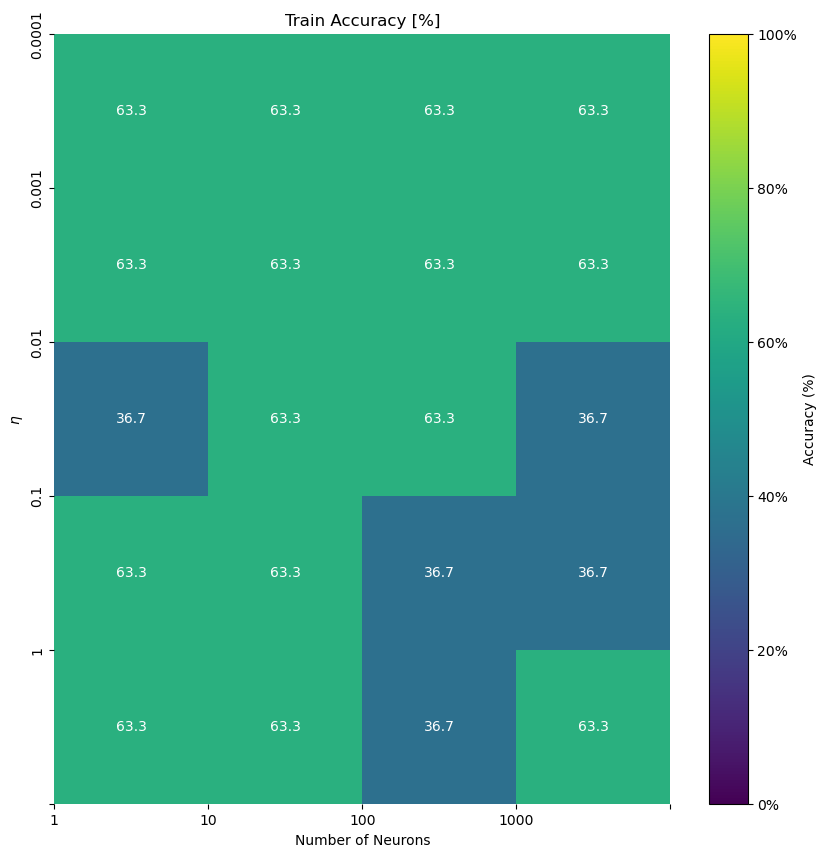

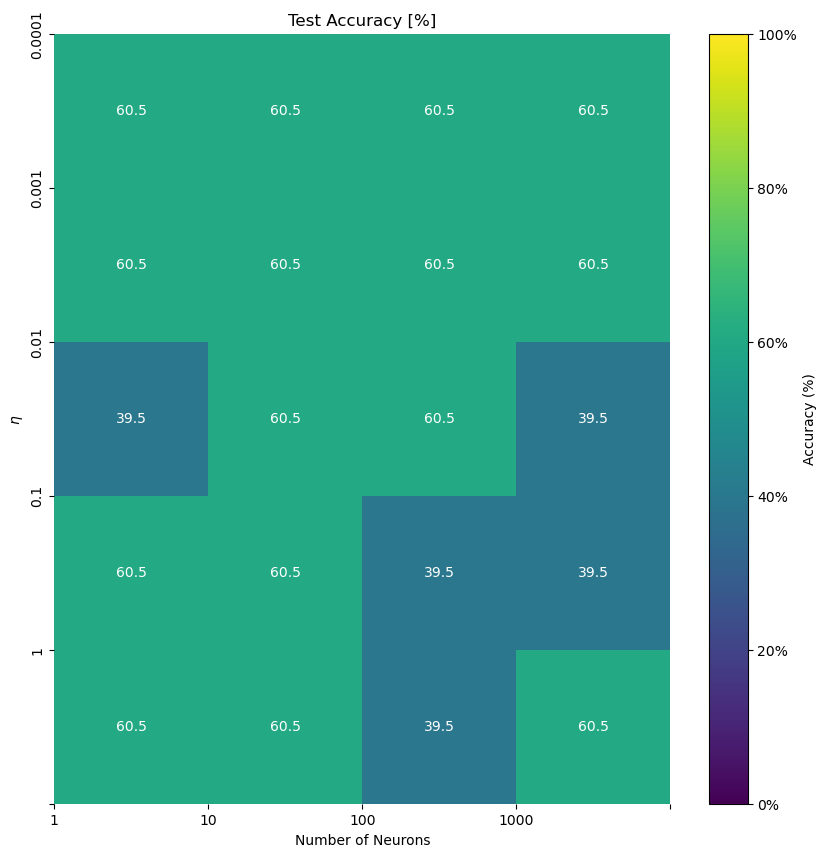

In [107]:
# Generate training and testing datasets
#Select features relevant to classification (texture,perimeter,compactness and symmetery) and add to input matrix
temp1 = np.reshape(x[:,1], (len(x[:,1]),1))
temp2 = np.reshape(x[:,2], (len(x[:,2]),1))
X = np.hstack((temp1, temp2))      
temp = np.reshape(x[:,5], (len(x[:,5]),1))
X = np.hstack((X,temp))       
temp = np.reshape(x[:,8], (len(x[:,8]),1))
X = np.hstack((X,temp))       

X_train, X_test, y_train, y_test = train_test_split_numpy(X, y, 0.8, 0.2)   #Split datasets into training and testing

del temp1,temp2,temp

# Define tunable parameters
n_inputs, n_features = X_train.shape
n_hidden_neurons = 50 
n_categories = 2
eta = 0.0001
lmbd = 0.0001

# Batch normalization
use_batch_norm = False
if use_batch_norm:
    hidden_bn = np.ones(n_hidden_neurons)
    output_bn = np.ones(n_categories)

# we make the weights normally distributed using numpy.random.randn
np.random.seed(0) # ensure the same random numbers appear every time
hidden_weights = np.random.randn(n_features, n_hidden_neurons) # weights in the hidden layer
hidden_bias = np.zeros(n_hidden_neurons) + 0.01 # bias in the hidden layer

# weights and bias in the output layer
output_weights = np.random.randn(n_hidden_neurons, n_categories)
output_bias = np.zeros(n_categories) + 0.01

print("Old accuracy on training data: " + str(accuracy_score(predict(X_train), y_train)))
print("Old accuracy on test data: " + str(accuracy_score(predict(X_test), y_test)))

y_train_onehot, y_test_onehot = to_categorical_numpy(y_train), to_categorical_numpy(y_test)
'''
for i in range(1):
    dWo, dBo, dWh, dBh = backpropagation(X_train, y_train_onehot) # calculate gradients
    a_h, probabilities = feed_forward(X_train)
    #print('ah',a_h, 'prob', probabilities)
    # regularization term gradients
    dWo += lmbd * output_weights
    dWh += lmbd * hidden_weights
    
    # update weights and biases
    output_weights -= eta * dWo
    output_bias -= eta * dBo
    hidden_weights -= eta * dWh
    hidden_bias -= eta * dBh

print("New accuracy on training data: " + str(accuracy_score(predict(X_train), y_train)))
#print(predict(X_train))
'''
'''
eta_vals = [0.0001, 0.001, 0.01, 0.1, 1]
lmbd_vals = [0.0001, 0.001, 0.01, 0.1, 1]

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
epochs = 1000

for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        for k in range(epochs):
            dWo, dBo, dWh, dBh = backpropagation(X_train, y_train_onehot)

            if use_batch_norm:
                hidden_bn = batch_normalize(hidden_bn)
                output_bn = batch_normalize(output_bn)
                dWo += lmbd * output_weights
                dWh += lmbd * hidden_weights
                output_weights -= eta * (dWo * output_bn)
                output_bias -= eta * (dBo * output_bn)
                hidden_weights -= eta * (dWh * hidden_bn)
                hidden_bias -= eta * (dBh * hidden_bn)
            else:
                dWo += lmbd * output_weights
                dWh += lmbd * hidden_weights
                output_weights -= eta * dWo
                output_bias -= eta * dBo
                hidden_weights -= eta * dWh
                hidden_bias -= eta * dBh
        
        train_accuracy[i][j] = accuracy_score(predict(X_train), y_train)
        test_accuracy[i][j] = accuracy_score(predict(X_test), y_test)

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax.set_title("Train Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()        

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", xticklabels=lmbd_vals, yticklabels=eta_vals)
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()
'''
# _________________________________________________________

eta_vals = [0.0001, 0.001, 0.01, 0.1, 1]
neurons = [1, 10, 100, 1000]

train_accuracy = np.zeros((len(eta_vals), len(neurons)))
test_accuracy = np.zeros((len(eta_vals), len(neurons)))
epochs = 1000
lmbd = 0.01

for i, eta in enumerate(eta_vals):
    for j, neu in enumerate(neurons):
        for k in range(epochs):
            n_hidden_neurons = neu
            dWo, dBo, dWh, dBh = backpropagation(X_train, y_train_onehot)

            if use_batch_norm:
                hidden_bn = batch_normalize(hidden_bn)
                output_bn = batch_normalize(output_bn)
                dWo += lmbd * output_weights
                dWh += lmbd * hidden_weights
                output_weights -= eta * (dWo * output_bn)
                output_bias -= eta * (dBo * output_bn)
                hidden_weights -= eta * (dWh * hidden_bn)
                hidden_bias -= eta * (dBh * hidden_bn)
            else:
                dWo += lmbd * output_weights
                dWh += lmbd * hidden_weights
                output_weights -= eta * dWo
                output_bias -= eta * dBo
                hidden_weights -= eta * dWh
                hidden_bias -= eta * dBh
        
        train_accuracy[i][j] = accuracy_score(predict(X_train), y_train)
        test_accuracy[i][j] = accuracy_score(predict(X_test), y_test)
        
def plot(data, x, y):
    data *= 100
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(data, annot=True, ax=ax, cmap="viridis", fmt=".1f",  vmin=0, vmax=100, cbar = False)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=100, cmap="viridis")
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('Accuracy (%)',rotation=90)
    cbar.set_ticks([0, 20, 40, 60, 80, 100])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])
    ax.set_xticklabels(str(i) for i in x)
    ax.set_yticklabels(str(i) for i in y)
    ax.xaxis.set_ticks_position('bottom')
    if str(data) == str(train_accuracy):
        ax.set_title("Train Accuracy [%]")
    elif str(data) == str(test_accuracy):
        ax.set_title("Test Accuracy [%]")
    ax.set_ylabel("$\eta$")
    ax.set_xlabel("Number of Neurons")
    plt.show() 

'''  
train_accuracy*=100
test_accuracy*=100     

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis",  vmin=0, vmax=100, cbar = False)
cax = ax.matshow(train_accuracy, interpolation='nearest', vmin=0, vmax=100)
cbar=fig.colorbar(cax)
cbar.ax.set_ylabel('Accuracy (%)',rotation=90)
cbar.set_ticks([0, 20, 40, 60, 80, 100])
cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_xticklabels(str(i) for i in neurons)
ax.set_yticklabels(str(i) for i in eta_vals)
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Train Accuracy [%]")
ax.set_ylabel("$\eta$")
ax.set_xlabel("Number of Neurons")
plt.show()        

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", xticklabels=neurons, yticklabels=eta_vals, vmin=0, vmax=100, cbar = False)
cax = ax.matshow(test_accuracy, interpolation='nearest', vmin=0, vmax=100)
cbar=fig.colorbar(cax)
cbar.ax.set_ylabel('Accuracy (%)',rotation=90)
cbar.set_ticks([0, 20, 40, 60, 80, 100])
cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_xticklabels(str(i) for i in neurons)
ax.set_yticklabels(str(i) for i in eta_vals)
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Test Accuracy [%]")
ax.set_ylabel("$\eta$")
ax.set_xlabel("number of neurons")
plt.show()
'''

plot(train_accuracy, neurons, eta_vals)
plot(test_accuracy, neurons, eta_vals)

### Classification using object-oriented code

In [108]:
from sklearn.datasets import load_breast_cancer
import pickle
import os 

# Loading dataset
np.random.seed(0)        #create same seed for random number every time
cancer=load_breast_cancer()      #Download breast cancer dataset
inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

#Print information about the datasets
print('The content of the breast cancer dataset is:')
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

#Reassign the Feature and Label matrices to other variables
x = inputs 
y = outputs

# Generate training and testing datasets
#Select features relevant to classification (texture,perimeter,compactness and symmetery) and add to input matrix
temp1 = np.reshape(x[:,1], (len(x[:,1]),1))
temp2 = np.reshape(x[:,2], (len(x[:,2]),1))
X = np.hstack((temp1, temp2))      
temp = np.reshape(x[:,5], (len(x[:,5]),1))
X = np.hstack((X,temp))       
temp = np.reshape(x[:,8], (len(x[:,8]),1))
X = np.hstack((X,temp))       

X_train, X_test, y_train, y_test = train_test_split_numpy(X, y, 0.8, 0.2)   #Split datasets into training and testing

del temp1,temp2,temp

The content of the breast cancer dataset is:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
-------------------------
inputs =  (569, 30)
outputs =  (569,)
labels =  (30,)


In [109]:
class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=2,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()

C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\3941284349.py:16: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\4150047889.py:43: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(self.z_o)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\4150047889.py:44: RuntimeWarning: invalid value encountered in divide
  self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\3941117290.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str(i) for i in neurons)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\3941117290.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(i) for i in eta_vals)


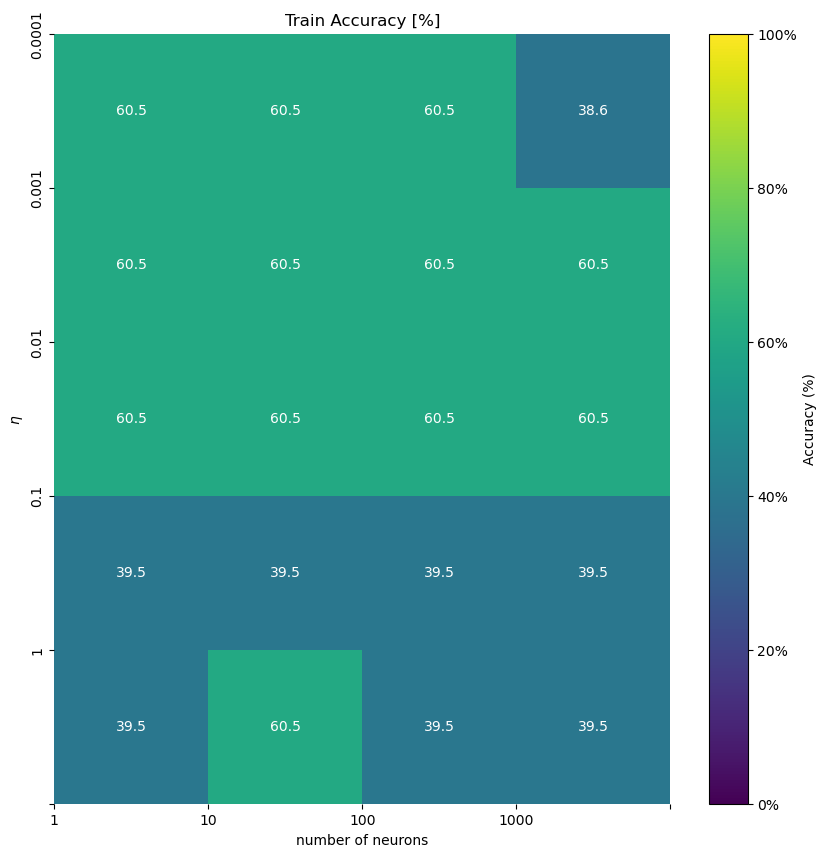

C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\3941117290.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str(i) for i in neurons)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\3941117290.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(str(i) for i in eta_vals)


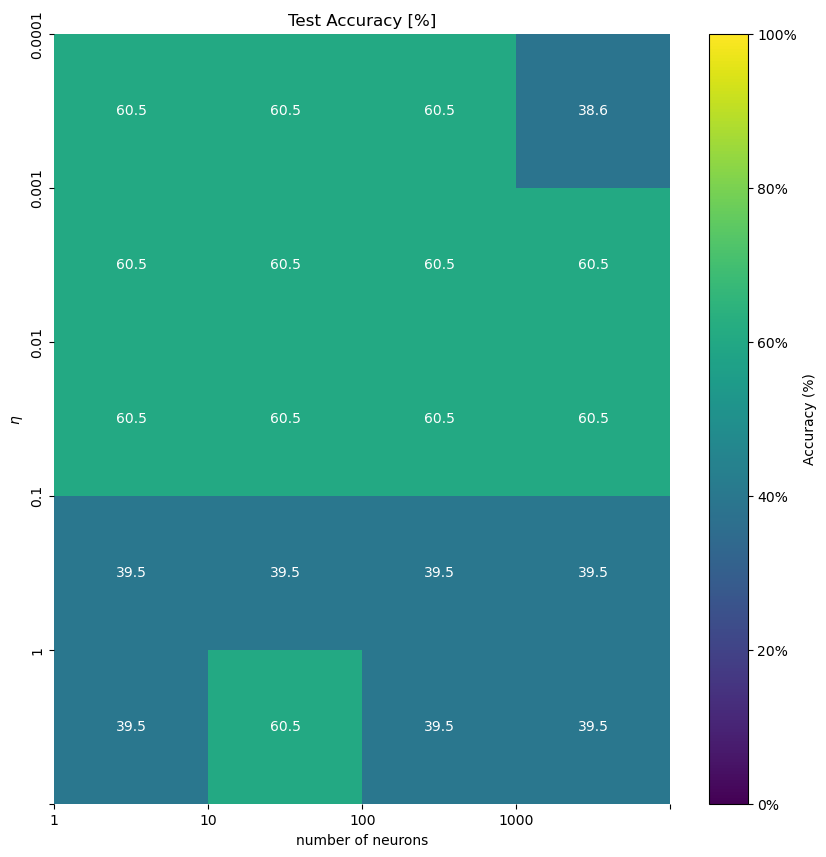

In [110]:
# equivalent in numpy
def accuracy_score_numpy(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

#eta_vals = np.logspace(-5, 1, 7)
#lmbd_vals = np.logspace(-5, 1, 7)

n_categories = 2
epochs = 1000
batch_size = 100
lmbd = 0.01
eta_vals = [0.0001, 0.001, 0.01, 0.1, 1]
neurons = [1, 10, 100, 1000]

DNN_numpy = np.zeros((len(eta_vals), len(neurons)), dtype=object)
test_accuracy = np.zeros((len(eta_vals), len(neurons)))

# grid search
for i, eta in enumerate(eta_vals):
    for j, neuron in enumerate(neurons):
        dnn = NeuralNetwork(X_train, y_train_onehot, eta=eta, lmbd=lmbd, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=neuron, n_categories=n_categories)
        dnn.train()
        DNN_numpy[i][j] = dnn
        train_predict = dnn.predict(X_train)
        test_predict = dnn.predict(X_test)
        '''
        print("Learning rate  = ", eta)
        print("Neurons = ", neuron)
        print("Accuracy score on training set: ", accuracy_score(y_train, train_predict))
        print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        '''
        train_accuracy[i][j] = accuracy_score(y_test, test_predict)
        test_accuracy[i][j] = accuracy_score(y_test, test_predict)

train_accuracy*=100
test_accuracy*=100

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, fmt=".1f", cmap="viridis", xticklabels=neurons, yticklabels=eta_vals, vmin=0, vmax=100, cbar = False)
cax = ax.matshow(train_accuracy, interpolation='nearest', vmin=0, vmax=100)
cbar=fig.colorbar(cax)
cbar.ax.set_ylabel('Accuracy (%)',rotation=90)
cbar.set_ticks([0, 20, 40, 60, 80, 100])
cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_xticklabels(str(i) for i in neurons)
ax.set_yticklabels(str(i) for i in eta_vals)
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Train Accuracy [%]")
ax.set_ylabel("$\eta$")
ax.set_xlabel("number of neurons")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, fmt=".1f", cmap="viridis", xticklabels=neurons, yticklabels=eta_vals, vmin=0, vmax=100, cbar = False)
cax = ax.matshow(test_accuracy, interpolation='nearest', vmin=0, vmax=100)
cbar=fig.colorbar(cax)
cbar.ax.set_ylabel('Accuracy (%)',rotation=90)
cbar.set_ticks([0, 20, 40, 60, 80, 100])
cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])
ax.set_xticklabels(str(i) for i in neurons)
ax.set_yticklabels(str(i) for i in eta_vals)
ax.xaxis.set_ticks_position('bottom')
ax.set_title("Test Accuracy [%]")
ax.set_ylabel("$\eta$")
ax.set_xlabel("number of neurons")
plt.show()

# Classification using tensorflow/keras

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7210 - accuracy: 0.6133
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7184 - accuracy: 0.6367
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.6367
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7144 - accuracy: 0.6367
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7127 - accuracy: 0.6367
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7109 - accuracy: 0.6367
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7095 - accuracy: 0.6367
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7086 - accuracy: 0.6367
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7073 - accuracy: 0.6367
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.7060 - accuracy: 0.6367
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.6367
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.6367
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6791 - accuracy: 0.6367
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.6367
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.6367
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6789 - accuracy: 0.6367
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.6367
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.6367
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.6367
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.6367
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7452 - accuracy: 0.5820
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7431 - accuracy: 0.6367
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7408 - accuracy: 0.6367
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7389 - accuracy: 0.6367
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 0.7369 - accuracy: 0.6367
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7351 - accuracy: 0.6367
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7331 - accuracy: 0.6367
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.7313 - accuracy: 0.6367
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7298 - accuracy: 0.6367
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7284 - accuracy: 0.6367
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.6367
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6988 - accuracy: 0.6367
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.6367
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.6367
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.6367
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.6367
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.6367
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6981 - accuracy: 0.6367
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.6367
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6979 - accuracy: 0.6367
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 2.0077 - accuracy: 0.5859
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7155 - accuracy: 0.6367
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7134 - accuracy: 0.6367
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7117 - accuracy: 0.6367
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7096 - accuracy: 0.6367
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7082 - accuracy: 0.6367
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7067 - accuracy: 0.6367
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7053 - accuracy: 0.6367
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7039 - accuracy: 0.6367
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7029 - accuracy: 0.6367
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.6367
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6773 - accuracy: 0.6367
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6772 - accuracy: 0.6367
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.6367
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6771 - accuracy: 0.6367
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.6367
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6770 - accuracy: 0.6367
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6769 - accuracy: 0.6367
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.6367
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.6367
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 4.8987 - accuracy: 0.5605
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 1.0121 - accuracy: 0.4961
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.9454 - accuracy: 0.5527
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8366 - accuracy: 0.6406
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8887 - accuracy: 0.5977
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8799 - accuracy: 0.5918
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8002 - accuracy: 0.6602
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8148 - accuracy: 0.6055
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8005 - accuracy: 0.6367
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8982 - accuracy: 0.5742
Epoch 11/100
6/6 [===========

6/6 [==============================] - 0s 2ms/step - loss: 0.7042 - accuracy: 0.7188
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.7363
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7206 - accuracy: 0.7383
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7179 - accuracy: 0.7070
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7036 - accuracy: 0.7207
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6949 - accuracy: 0.7344
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.7285
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7124 - accuracy: 0.7090
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7054 - accuracy: 0.7207
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7011 - accuracy: 0.7207
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 10.3550 - accuracy: 0.4570
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8643 - accuracy: 0.5977
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8578 - accuracy: 0.5762
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8975 - accuracy: 0.6270
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7857 - accuracy: 0.6973
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7992 - accuracy: 0.6172
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7913 - accuracy: 0.6504
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8016 - accuracy: 0.6465
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7797 - accuracy: 0.6543
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8062 - accuracy: 0.6289
Epoch 11/100
6/6 [==========

6/6 [==============================] - 0s 2ms/step - loss: 0.7087 - accuracy: 0.7090
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6993 - accuracy: 0.7285
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7234 - accuracy: 0.7090
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7026 - accuracy: 0.7285
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7029 - accuracy: 0.6953
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.7266
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.7344
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7003 - accuracy: 0.7109
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.7129
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7121 - accuracy: 0.7051
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 10.2156 - accuracy: 0.5625
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 0.8804 - accuracy: 0.5703
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7949 - accuracy: 0.6367
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 0.8040 - accuracy: 0.6367
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7904 - accuracy: 0.6367
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7932 - accuracy: 0.6367
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7877 - accuracy: 0.6367
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7781 - accuracy: 0.6367
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7785 - accuracy: 0.6367
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7839 - accuracy: 0.6367
Epoch 11/100
6/6 [==========

6/6 [==============================] - 0s 2ms/step - loss: 0.7373 - accuracy: 0.6367
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7349 - accuracy: 0.6367
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7327 - accuracy: 0.6367
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7316 - accuracy: 0.6367
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7348 - accuracy: 0.6367
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7439 - accuracy: 0.6367
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7442 - accuracy: 0.6367
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7357 - accuracy: 0.6367
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7311 - accuracy: 0.6367
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 0.7321 - accuracy: 0.6367
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 14.0736 - accuracy: 0.5508
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 2.2395 - accuracy: 0.5176
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7105 - accuracy: 0.6328
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7238 - accuracy: 0.6387
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6772 - accuracy: 0.6621
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7466 - accuracy: 0.5840
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6899 - accuracy: 0.6426
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6768 - accuracy: 0.6426
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6911 - accuracy: 0.6152
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6690 - accuracy: 0.6680
Epoch 11/100
6/6 [==========

6/6 [==============================] - 0s 2ms/step - loss: 1.4488 - accuracy: 0.7188
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4546 - accuracy: 0.7148
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4504 - accuracy: 0.7285
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4452 - accuracy: 0.7246
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4409 - accuracy: 0.6953
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4400 - accuracy: 0.7227
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4371 - accuracy: 0.7109
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4368 - accuracy: 0.7227
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4273 - accuracy: 0.7344
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4557 - accuracy: 0.6855
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 16.5045 - accuracy: 0.5137
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 1.8431 - accuracy: 0.5723
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7610 - accuracy: 0.6211
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 1.8401 - accuracy: 0.5312
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 1.7523 - accuracy: 0.5879
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 1.7052 - accuracy: 0.6367
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 1.7100 - accuracy: 0.6602
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6961 - accuracy: 0.6426
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 1.7367 - accuracy: 0.6309
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7124 - accuracy: 0.6152
Epoch 11/100
6/6 [==========

6/6 [==============================] - 0s 3ms/step - loss: 1.4568 - accuracy: 0.7305
Epoch 85/100
6/6 [==============================] - 0s 3ms/step - loss: 1.4563 - accuracy: 0.7344
Epoch 86/100
6/6 [==============================] - 0s 3ms/step - loss: 1.4527 - accuracy: 0.7266
Epoch 87/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4784 - accuracy: 0.7266
Epoch 88/100
6/6 [==============================] - 0s 5ms/step - loss: 1.4459 - accuracy: 0.7305
Epoch 89/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4483 - accuracy: 0.7012
Epoch 90/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4579 - accuracy: 0.7129
Epoch 91/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4390 - accuracy: 0.7422
Epoch 92/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4509 - accuracy: 0.7070
Epoch 93/100
6/6 [==============================] - 0s 4ms/step - loss: 1.4353 - accuracy: 0.7227
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 10.8745 - accuracy: 0.5586
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 1.8317 - accuracy: 0.5469
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7270 - accuracy: 0.6133
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7688 - accuracy: 0.6289
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7017 - accuracy: 0.6348
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6943 - accuracy: 0.6621
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6789 - accuracy: 0.6758
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7011 - accuracy: 0.6387
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7184 - accuracy: 0.6426
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6783 - accuracy: 0.6602
Epoch 11/100
6/6 [==========

6/6 [==============================] - 0s 3ms/step - loss: 1.4606 - accuracy: 0.7129
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4495 - accuracy: 0.7305
Epoch 86/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4482 - accuracy: 0.7207
Epoch 87/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4497 - accuracy: 0.7051
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4457 - accuracy: 0.7324
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4418 - accuracy: 0.7246
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4388 - accuracy: 0.7324
Epoch 91/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4375 - accuracy: 0.7129
Epoch 92/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4372 - accuracy: 0.7266
Epoch 93/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4358 - accuracy: 0.7148
Epoch 94/100
6/6 [===============

Epoch 1/100
6/6 [==============================] - 1s 12ms/step - loss: 21.0984 - accuracy: 0.4766
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 10.8139 - accuracy: 0.4941
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 10.7717 - accuracy: 0.5293
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 10.6471 - accuracy: 0.6074
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 10.6086 - accuracy: 0.6406
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 10.5696 - accuracy: 0.6348
Epoch 7/100
6/6 [==============================] - 0s 12ms/step - loss: 10.5941 - accuracy: 0.6309
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 10.5513 - accuracy: 0.6348
Epoch 9/100
6/6 [==============================] - 0s 12ms/step - loss: 10.4966 - accuracy: 0.6562
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 10.4730 - accuracy: 0.6387
Epoch 11/

6/6 [==============================] - 0s 11ms/step - loss: 8.8516 - accuracy: 0.7129
Epoch 84/100
6/6 [==============================] - 0s 10ms/step - loss: 8.8204 - accuracy: 0.7070
Epoch 85/100
6/6 [==============================] - 0s 10ms/step - loss: 8.8135 - accuracy: 0.7051
Epoch 86/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7725 - accuracy: 0.7168
Epoch 87/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7542 - accuracy: 0.7207
Epoch 88/100
6/6 [==============================] - 0s 12ms/step - loss: 8.7363 - accuracy: 0.7148
Epoch 89/100
6/6 [==============================] - 0s 12ms/step - loss: 8.7147 - accuracy: 0.7227
Epoch 90/100
6/6 [==============================] - 0s 12ms/step - loss: 8.6939 - accuracy: 0.7227
Epoch 91/100
6/6 [==============================] - 0s 13ms/step - loss: 8.6871 - accuracy: 0.7012
Epoch 92/100
6/6 [==============================] - 0s 16ms/step - loss: 8.6580 - accuracy: 0.7285
Epoch 93/100
6/6 [=====

Epoch 1/100
6/6 [==============================] - 0s 9ms/step - loss: 23.3626 - accuracy: 0.5273
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 10.9704 - accuracy: 0.5664
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 10.6821 - accuracy: 0.5547
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 10.6348 - accuracy: 0.6152
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 10.6284 - accuracy: 0.6465
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 10.5587 - accuracy: 0.6250
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 10.5203 - accuracy: 0.6582
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 10.5092 - accuracy: 0.6680
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 10.4621 - accuracy: 0.6816
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 10.5075 - accuracy: 0.5957
Epoch 11/100


6/6 [==============================] - 0s 10ms/step - loss: 8.8353 - accuracy: 0.7500
Epoch 84/100
6/6 [==============================] - 0s 11ms/step - loss: 8.8068 - accuracy: 0.6914
Epoch 85/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7913 - accuracy: 0.7168
Epoch 86/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7617 - accuracy: 0.7324
Epoch 87/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7428 - accuracy: 0.7148
Epoch 88/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7227 - accuracy: 0.6992
Epoch 89/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6994 - accuracy: 0.7461
Epoch 90/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6813 - accuracy: 0.7285
Epoch 91/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6575 - accuracy: 0.7305
Epoch 92/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6532 - accuracy: 0.7207
Epoch 93/100
6/6 [=====

Epoch 1/100
6/6 [==============================] - 0s 8ms/step - loss: 25.6515 - accuracy: 0.4609
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 10.8060 - accuracy: 0.5547
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 10.6871 - accuracy: 0.6211
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 10.6430 - accuracy: 0.6602
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 10.6044 - accuracy: 0.6348
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 10.5711 - accuracy: 0.6523
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 10.5918 - accuracy: 0.6602
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 10.5250 - accuracy: 0.6738
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 10.5303 - accuracy: 0.6152
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 10.4613 - accuracy: 0.6543
Epoch 11/100
6/6 

6/6 [==============================] - 0s 9ms/step - loss: 8.8622 - accuracy: 0.7051
Epoch 84/100
6/6 [==============================] - 0s 10ms/step - loss: 8.8323 - accuracy: 0.7031
Epoch 85/100
6/6 [==============================] - 0s 10ms/step - loss: 8.8085 - accuracy: 0.7285
Epoch 86/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7832 - accuracy: 0.7324
Epoch 87/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7626 - accuracy: 0.7285
Epoch 88/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7474 - accuracy: 0.7031
Epoch 89/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7277 - accuracy: 0.7012
Epoch 90/100
6/6 [==============================] - 0s 10ms/step - loss: 8.7048 - accuracy: 0.7207
Epoch 91/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6887 - accuracy: 0.7207
Epoch 92/100
6/6 [==============================] - 0s 10ms/step - loss: 8.6647 - accuracy: 0.7051
Epoch 93/100
6/6 [======

C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\982986787.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+x)
C:\Users\IFE12739\AppData\Local\Temp\ipykernel_28128\982986787.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+y)


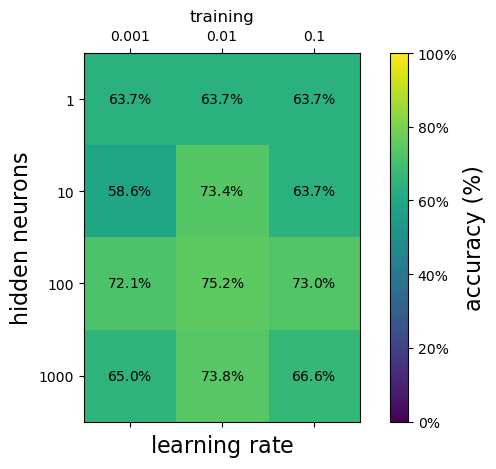

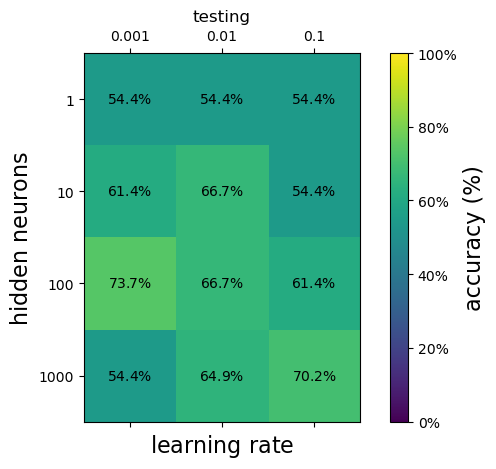

In [111]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from sklearn.model_selection import train_test_split as splitter

x=inputs #Reassign the Feature and Label matrices to other variables
y=outputs

# Generate training and testing datasets
#Select features relevant to classification (texture,perimeter,compactness and symmetery) 
#and add to input matrix
temp1=np.reshape(x[:,1],(len(x[:,1]),1))
temp2=np.reshape(x[:,2],(len(x[:,2]),1))
X=np.hstack((temp1,temp2))      
temp=np.reshape(x[:,5],(len(x[:,5]),1))
X=np.hstack((X,temp))       
temp=np.reshape(x[:,8],(len(x[:,8]),1))
X=np.hstack((X,temp))       

X_train,X_test,y_train,y_test=splitter(X,y,test_size=0.1)   #Split datasets into training and testing
y_train=to_categorical(y_train)     #Convert labels to categorical when using categorical cross entropy
y_test=to_categorical(y_test)

del temp1,temp2,temp

# Define tunable parameters
eta=np.logspace(-3,-1,3)                    #Define vector of learning rates (parameter to SGD optimiser)
lamda=0.01                                  #Define hyperparameter
n_layers=2                                  #Define number of hidden layers in the model
n_neuron=np.logspace(0,3,4,dtype=int)       #Define number of neurons per layer
epochs=100                                   #Number of reiterations over the input data
batch_size=100                              #Number of samples per gradient update

# Define function to return Deep Neural Network model
def NN_model(inputsize,n_layers,n_neuron,eta,lamda):
    model=Sequential()      
    for i in range(n_layers):       #Run loop to add hidden layers to the model
        if (i==0):                  #First layer requires input dimensions
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda),input_dim=inputsize))
        else:                       #Subsequent layers are capable of automatic shape inferencing
            model.add(Dense(n_neuron,activation='relu',kernel_regularizer=regularizers.l2(lamda)))
    model.add(Dense(2,activation='softmax'))  #2 outputs - ordered and disordered (softmax for prob)
    sgd=optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model
    
Train_accuracy=np.zeros((len(n_neuron),len(eta)))      #Define matrices to store accuracy scores as a function
Test_accuracy=np.zeros((len(n_neuron),len(eta)))       #of learning rate and number of hidden neurons for 

for i in range(len(n_neuron)):     #run loops over hidden neurons and learning rates to calculate 
    for j in range(len(eta)):      #accuracy scores 
        DNN_model=NN_model(X_train.shape[1],n_layers,n_neuron[i],eta[j],lamda)
        DNN_model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)
        Train_accuracy[i,j]=DNN_model.evaluate(X_train,y_train)[1]
        Test_accuracy[i,j]=DNN_model.evaluate(X_test,y_test)[1]   

def plot_data(x,y,data,title=None):
    fontsize=16
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    x=[str(i) for i in x]     # convert axis vaues to to string labels
    y=[str(i) for i in y]

    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)
    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
plot_data(eta,n_neuron,Train_accuracy, 'training')
plot_data(eta,n_neuron,Test_accuracy, 'testing')